### Importando as bibliotecas que serão utilizadas ao decorrer dos códigos

In [32]:
# Executando os imports necessários para rodar o projeto
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregamento dos Dados

Aqui realizamos a leitura do conjunto de dados Nomao, esse armazenado nos arquivos `.data` e `.features`.  

- O arquivo **Nomao.features** contém os nomes das colunas.
- O arquivo **Nomao.data** contém os registros que analisaremos.

Após a leitura, convertemos esses arquivos em um DataFrame do Pandas para facilitar as operações futuras.


In [33]:
import os


file_path_features = os.path.join(os.getcwd(), "Nomao.features")
with open(file_path_features, 'r') as file:
    content_features = file.read()

file_path_data = os.path.join(os.getcwd(), "Nomao.data")
with open(file_path_data, 'r') as file:
    content_data = file.read()

features = content_features.split('\n')
data = list(map(lambda x: x.split(','), content_data.split('\n')))


# Primeira Visualização do Dataset

Antes de realizar qualquer transformação, é importante visualizar os primeiros registros para entender sua estrutura.
 
**Alvo da observação**  
- Os tipos de dados das colunas  
- A presença de valores ausentes (`?`)  
- A existência de colunas categóricas e numéricas  

Essa etapa inicial nos ajuda a definir as melhores estratégias de tratamento dos dados!


In [34]:
# Inicializando DataFrame do Nomao
nomao_df = pd.DataFrame(data, columns=features)
nomao_df.head(5)

,id,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,clean_name_including,clean_name_equality,city_intersect_min,...,coordinates_long_levenshtein,coordinates_long_trigram,coordinates_long_equality,coordinates_lat_diff,coordinates_lat_levenshtein,coordinates_lat_trigram,coordinates_lat_equality,geocode_coordinates_diff,coordinates_diff,label
0,0#1,1,1,1,1,1,1,s,s,?,...,0.75,0.5,n,0.999953002209,0.777777777778,0.461538463831,n,1.0,0.999999996702,+1
1,0#2,1,0.75,0.857143,0.857143,0.894737,0.947368,s,n,?,...,0.5,0.307692319155,n,0.999982921892,0.538461538462,0.4375,n,1.0,0.999999962459,+1
2,0#3,1,1,1,1,1,1,s,s,?,...,0.666666666667,0.461538463831,n,0.999992600055,0.8,0.666666686535,n,1.0,0.999999999653,+1
3,4#5,1,0.75,0.857143,0.857143,0.842105,0.833333,s,n,1,...,0.5,0.285714298487,n,0.998604948886,0.555555555556,0.384615391493,n,0.999999947284,0.999994124065,+1
4,6#7,0,0,0.25,0,0.25,0,n,n,?,...,?,?,m,?,?,?,m,1.0,?,+1


# 📊 Informações Gerais do Dataset

Agora vamos analisar a estrutura do DataFrame e obter estatísticas básicas.

📌 **Principais pontos analisados:**  
- Número total de linhas e colunas  
- Tipos de dados em cada coluna  

Essas informações são fundamentais para o próximo passo: o **pré-processamento**.


In [35]:
print(nomao_df.shape)

(34466, 120)


### Número de linhas e colunas
```python
# O dataset possui 34466 linhas e 120 colunas

In [36]:
nomao_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34466 entries, 0 to 34465
Columns: 120 entries, id to label
dtypes: object(120)
memory usage: 31.6+ MB


In [37]:
# Resumo estatístico das colunas numéricas (mesmo que estejam como 'object', aqui serve para uma noção inicial)
nomao_df.describe(include='all')


,id,clean_name_intersect_min,clean_name_intersect_max,clean_name_levenshtein_sim,clean_name_trigram_sim,clean_name_levenshtein_term,clean_name_trigram_term,clean_name_including,clean_name_equality,city_intersect_min,...,coordinates_long_levenshtein,coordinates_long_trigram,coordinates_long_equality,coordinates_lat_diff,coordinates_lat_levenshtein,coordinates_lat_trigram,coordinates_lat_equality,geocode_coordinates_diff,coordinates_diff,label
count,34466,34465,34465,34465,34465,34465,34465,34465,34465,34465,...,34465,34465,34465,34465,34465,34465,34465,34465,34465,34465
unique,33959,27,43,3942,2211,759,929,2,2,8,...,67,102,3,7164,56,104,3,8549,9382,2
top,12142#12143,1,0,1,1,1,1,s,n,?,...,?,?,m,?,?,?,m,1.0,?,+1
freq,2,17687,8935,8730,8730,8013,8759,17687,25735,22295,...,18965,18965,18965,18965,18965,18965,18965,15555,18965,24621


### Curiosidade interessante
```python 
# Observando o retorno acima, percebemos que, por exemplo, o ID não é único, algo intrigante pela natureza do dataset. Precisamos posteriormente estudar se isso pode causar problemas ou não, ou seja, se precisaremos tratar ou não.

#  Analisando o Balanceamento das Classes

A variável **label** do dataset indica se dois pontos referem-se ao mesmo local ou não.

**Por que isso importa?**  
- Se houver desbalanceamento (muitas instâncias de uma classe e poucas de outra), os modelos podem ficar **tendenciosos**.  
- Técnicas como **reponderação de classes, oversampling e undersampling** podem ser necessárias para corrigir isso.

Aqui, plotamos um gráfico para visualizar a proporção das classes no dataset.

In [38]:
label_col = nomao_df['label']
nomao_df = nomao_df.drop(columns=['label'])

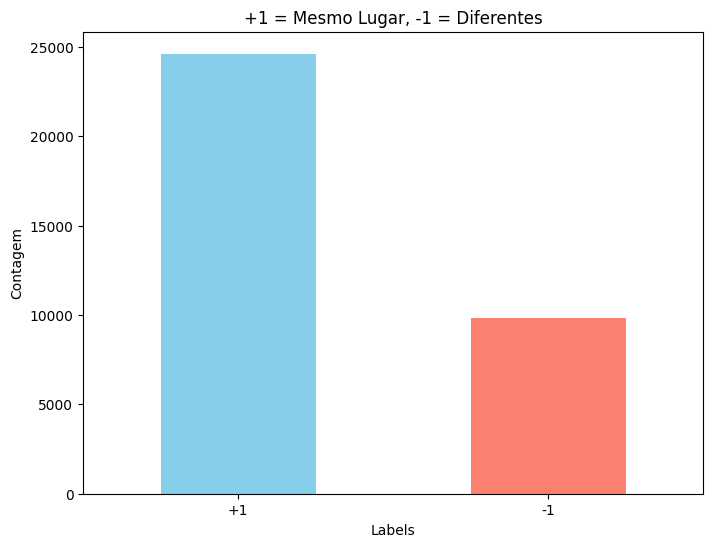

In [39]:
plt.figure(figsize=(8,6))
label_col.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('+1 = Mesmo Lugar, -1 = Diferentes')
plt.xlabel('Labels')
plt.ylabel('Contagem')
plt.xticks(rotation=0)
plt.show()


### Conclusão de balanceamento

É notório perceber que há uma clara quantidade maior de labels positivas do que negativas, resumindo, o modelo pode ser tendencioso para apontar que os locais são os mesmos pontos.

Essa falta de equilíbrio pode afetar a capacidade do modelo de identificar corretamente as instâncias negativas, o que pode resultar em um viés nas previsões. Para melhorar o desempenho e reduzir o viés, algumas abordagens podem ser consideradas:

1. Aplicar técnicas de balanceamento como undersampling ou oversampling.
2. Escolher nossos futuros algoritmos baseados nessa características do problema.
3. Ajustar a função de custo do modelo, atribuindo um peso maior para a classe minoritária.
4. Avaliar as métricas que utilizaremos, visto que o problema é desbalanceado e a acurácia pode não ser uma boa avaliação.


#  Separação de Variáveis Numéricas e Categóricas

Para facilitar as análises, dividimos as colunas do dataset em **numéricas** e **categóricas**.


In [40]:
# Exemplo de função que checa se a maioria dos valores são numéricos ou não
def transformar(series, threshold=0.9):
    filtragem_na = series.dropna()
    if len(filtragem_na) == 0:
        # Colunas inteiras de valores ausentes são consideradas não numéricas
        return False
    
    n_numeros = 0
    for val in filtragem_na:
        try:
            float(val)  # Tenta converter
            n_numeros += 1
        except ValueError:
            pass
    
    # Fracão de valores que foram convertidos com sucesso
    fraction = n_numeros / len(filtragem_na)
    
    return fraction >= threshold

# Da forma explicitada pelo autor, vamos substituir os valores '?' por NaN
nomao_df = nomao_df.replace('?', np.nan)


Colunas numéricas: 89
Colunas categóricas: 30


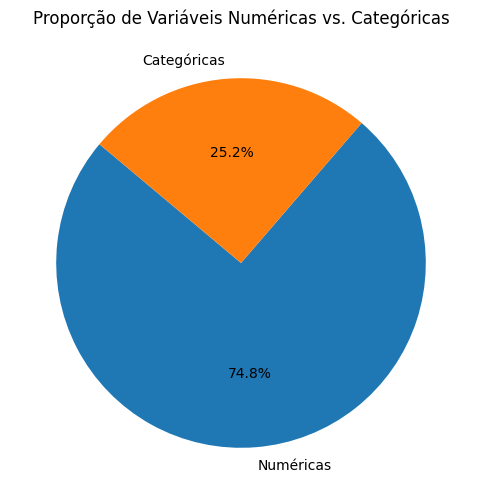

In [41]:
numericas = []
categoricas = []

for col in nomao_df.columns:
    # Se a coluna for convertível para numérico acima do threshold, convertemos
    if transformar(nomao_df[col], threshold=0.9):
        # Converter oficialmente para float (ou int) no DataFrame
        nomao_df[col] = pd.to_numeric(nomao_df[col], errors='coerce')
        numericas.append(col)
    else:
        categoricas.append(col)

print(f"Colunas numéricas: {len(numericas)}")
print(f"Colunas categóricas: {len(categoricas)}")

labels = ['Numéricas', 'Categóricas']
sizes = [len(numericas), len(categoricas)]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proporção de Variáveis Numéricas vs. Categóricas')
plt.show()


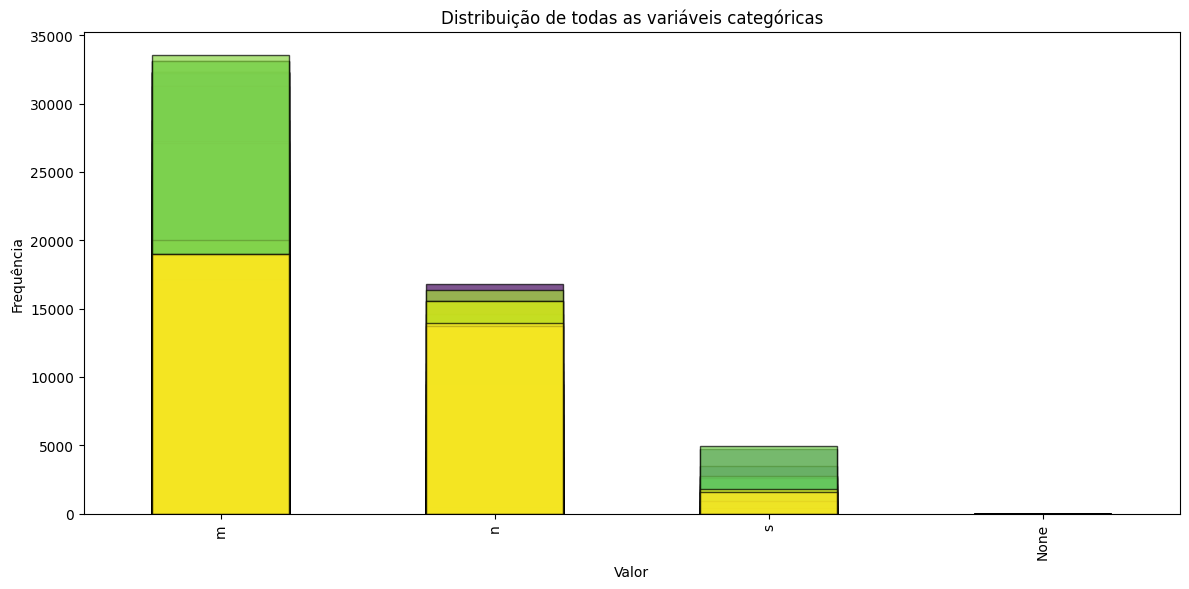

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Selecionando apenas as colunas categóricas
cat_cols = nomao_df.select_dtypes(include=['object']).columns

# Gerando uma paleta de cores
colors = plt.cm.viridis(np.linspace(0, 1, len(cat_cols)))  # Usando a paleta 'viridis'

# Plotando a distribuição das variáveis categóricas
plt.figure(figsize=(12, 6))

# Plotando todas as variáveis categóricas com cores diferenciadas
for i, col in enumerate(cat_cols):
    # Calculando a frequência de cada categoria (incluindo NaN)
    nomao_df[col].value_counts(dropna=False).plot(kind='bar', alpha=0.7, label=col, edgecolor='black', color=colors[i])

# Configurações do gráfico
plt.title('Distribuição de todas as variáveis categóricas')
plt.xlabel('Valor')
plt.ylabel('Frequência')


plt.tight_layout()

# Exibindo o gráfico
plt.show()


## Intervalo de valores contínuos

Vamos ver como é distribuído o intervalo de valores contínuos do dataset

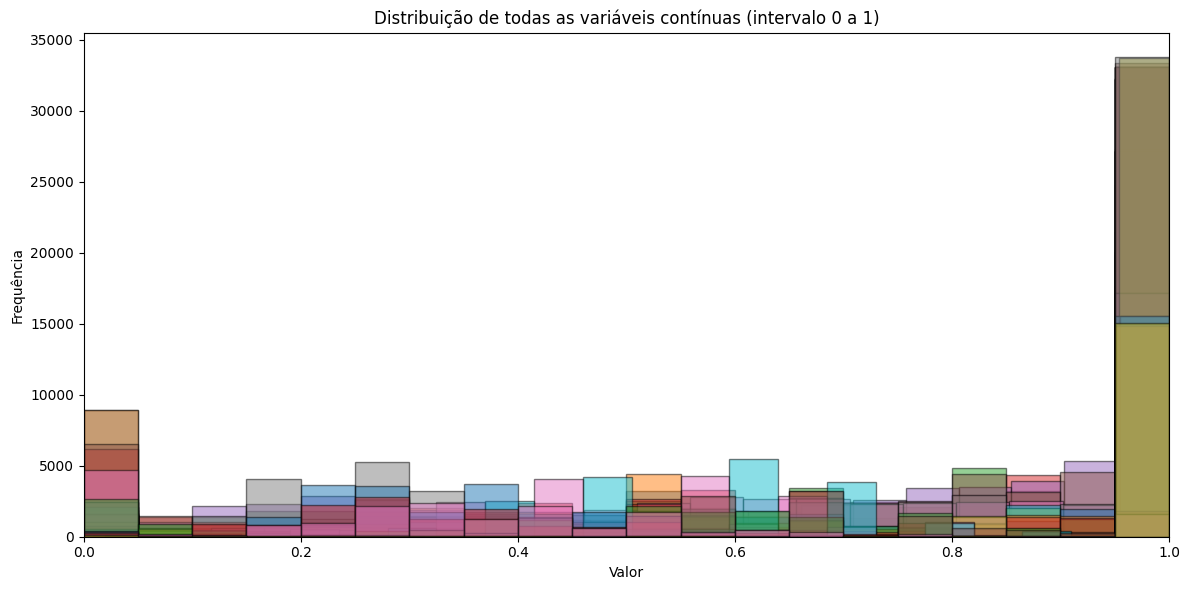

In [43]:


# Selecionando apenas as colunas numéricas contínuas
num_cols = nomao_df.select_dtypes(include=['float64', 'int64']).columns

# Plotando a distribuição das variáveis contínuas em um único histograma
plt.figure(figsize=(12, 6))

# Plotando todas as variáveis contínuas em um único gráfico
for col in num_cols:
    nomao_df[col].plot(kind='hist', bins=20, alpha=0.5, label=col, edgecolor='black')

# Configurações do gráfico
plt.title('Distribuição de todas as variáveis contínuas (intervalo 0 a 1)')
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.xlim(0, 1)  # Intervalo de 0 a 1

plt.tight_layout()

# Exibindo o gráfico
plt.show()


## Comentários

Aqui observamos que as colunas contínuas são distribuídas de forma que sempre ficam entre o intervalo de 0 a 1, ou seja, meio que normalizadas. O que levanta a dúvida se devemos ou não tratar os outliers que surgem de tal problema, visto que nesse caso não é de nossa expertise compreender se realmente os dados devem ser modificados, porém, segue abaixo o estudo de outliers

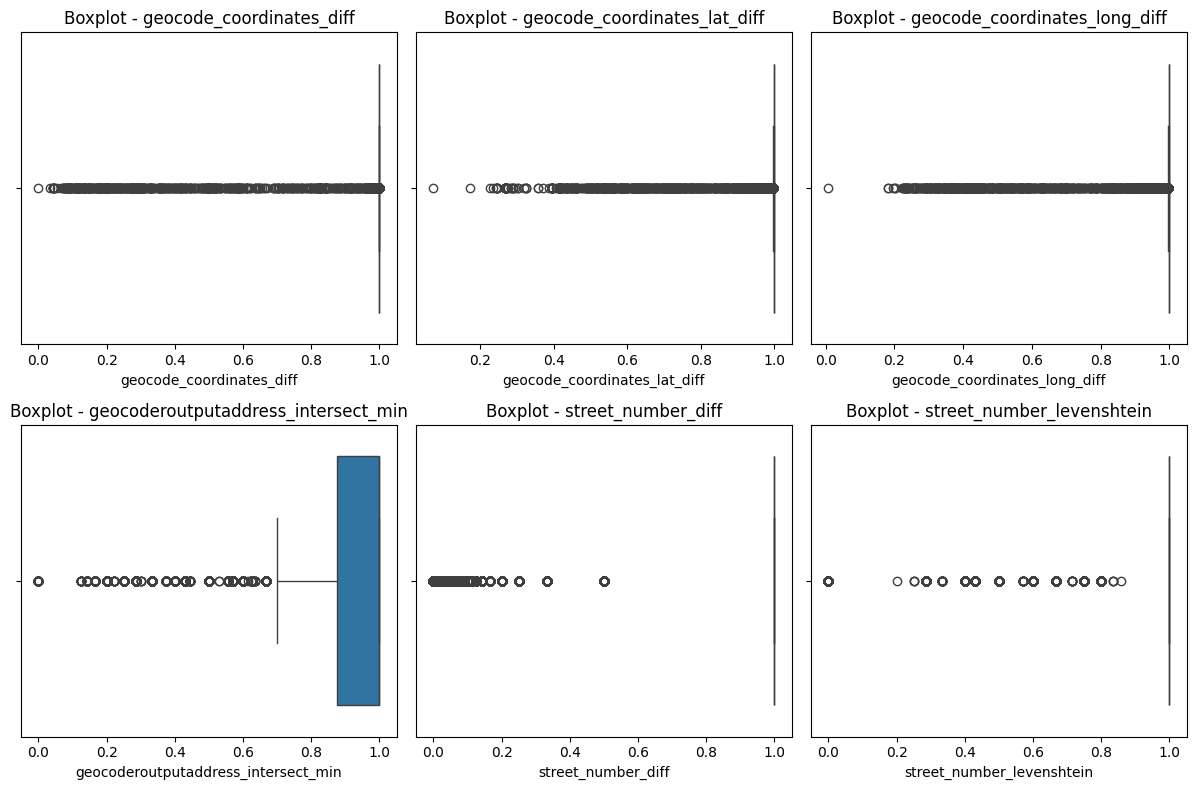

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculando o número de outliers para cada coluna
Q1 = nomao_df[num_cols].quantile(0.25)
Q3 = nomao_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((nomao_df[num_cols] < (Q1 - 1.5 * IQR)) | (nomao_df[num_cols] > (Q3 + 1.5 * IQR)))

# Contando o número de outliers por coluna
outliers_count = outliers.sum()

# Selecionando as 5 colunas com mais outliers
top_6_outliers = outliers_count.nlargest(6)

# Plotando os boxplots para as 5 colunas com mais outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(top_6_outliers.index):
    plt.subplot(2, 3, i+1)  # 2 linhas, 3 colunas de subplots
    sns.boxplot(x=nomao_df[col])
    plt.title(f'Boxplot - {col}')

plt.tight_layout()
plt.show()


In [45]:
outliers = {}

for col in num_cols:
    Q1 = nomao_df[col].quantile(0.25)
    Q3 = nomao_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Encontrando os outliers
    outliers[col] = nomao_df[(nomao_df[col] < lower_bound) | (nomao_df[col] > upper_bound)].shape[0]

# Exibindo os resultados
outliers_df = pd.DataFrame(list(outliers.items()), columns=["Feature", "Outliers Count"])
outliers_df = outliers_df.sort_values(by="Outliers Count", ascending=False)

from IPython.display import display, HTML
# Tornando a exibição rolável
display(HTML(outliers_df.to_html()))


,Feature,Outliers Count
87,geocode_coordinates_diff,7517
78,geocode_coordinates_lat_diff,6495
75,geocode_coordinates_long_diff,6477
48,geocoderoutputaddress_intersect_min,5906
72,street_number_diff,5297
73,street_number_levenshtein,5297
74,street_number_trigram,5297
88,coordinates_diff,3230
55,geocoderpostalcodenumber_intersect_max,2751
56,geocoderpostalcodenumber_levenshtein_sim,2751


Observamos então que existem outliers, mas esses outliers podem ser relacionados à natureza da localização do problema, logo, resolvemos a primeira vista não considerar como problema.

# Analisando Valores Ausentes

Um aspecto crítico na preparação dos dados é lidar com valores ausentes.  
No dataset NOMAO, os valores faltantes são representados pelo símbolo **`?`**.  

**Gráfico**  
- A porcentagem de valores ausentes em cada variável  

C:\Users\iantr\AppData\Local\Temp\ipykernel_1700\1427798497.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=faltantes_porcentagem.index, y=faltantes_porcentagem.values, palette='viridis')


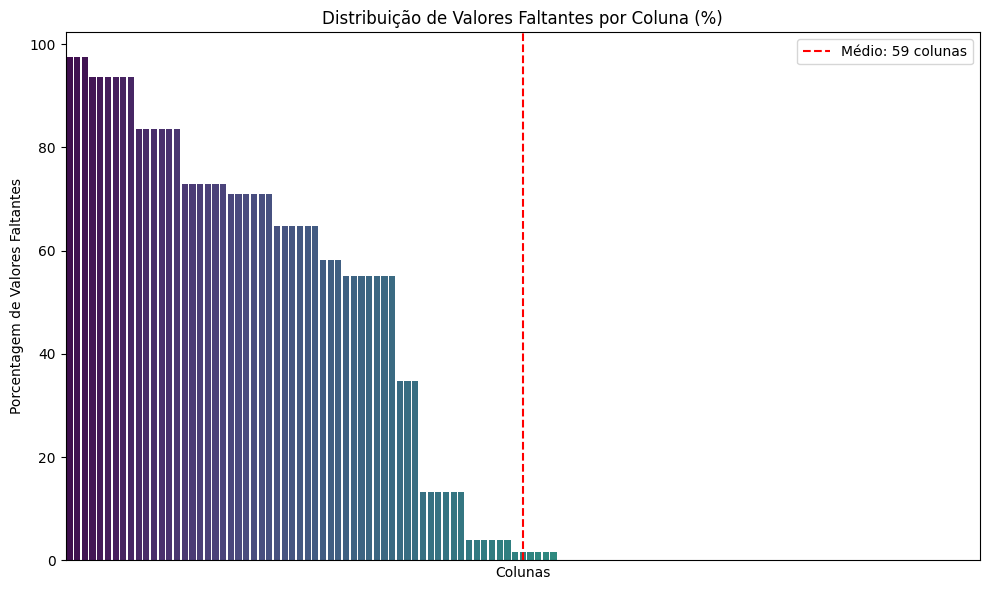

In [46]:


# Contar os valores faltantes por coluna
faltantes = nomao_df.isna().sum()

# Porcentagem de valores faltantes por coluna
faltantes_porcentagem = (faltantes / len(nomao_df)) * 100

# Ordenar as colunas por porcentagem de valores faltantes
faltantes_porcentagem = faltantes_porcentagem.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=faltantes_porcentagem.index, y=faltantes_porcentagem.values, palette='viridis')

# Escala
half_point = len(faltantes_porcentagem) // 2  # Meio do eixo x
plt.axvline(x=half_point, color='red', linestyle='--', label=f'Médio: {half_point} colunas')

# Configurações do gráfico
plt.title('Distribuição de Valores Faltantes por Coluna (%)')
plt.xlabel('Colunas')
plt.ylabel('Porcentagem de Valores Faltantes')
plt.xticks([])  # Para melhor visualização das colunas
plt.legend()
plt.tight_layout()

# Exibindo o gráfico
plt.show()


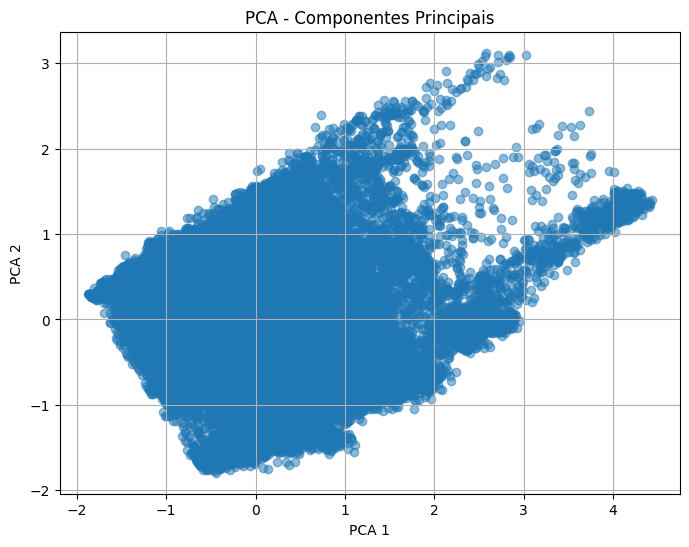

Variância explicada pelos componentes principais: [0.32373804 0.18042697]


In [47]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Selecionando apenas as colunas numéricas
num_cols = nomao_df.select_dtypes(include=['float64', 'int64']).columns

# Tratando valores ausentes (substituindo por média ou mediana)
nomao_df[num_cols] = nomao_df[num_cols].fillna(nomao_df[num_cols].mean())  # ou use mediana em vez de média

# Aplicando PCA
pca = PCA(n_components=2)  # Reduzindo para 2 componentes principais para visualização
pca_result = pca.fit_transform(nomao_df[num_cols])

# Criando um DataFrame com os componentes principais
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Plotando os resultados do PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], alpha=0.5)
plt.title('PCA - Componentes Principais')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# Verificando a variância explicada
explained_variance = pca.explained_variance_ratio_
print(f"Variância explicada pelos componentes principais: {explained_variance}")


c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\iantr\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


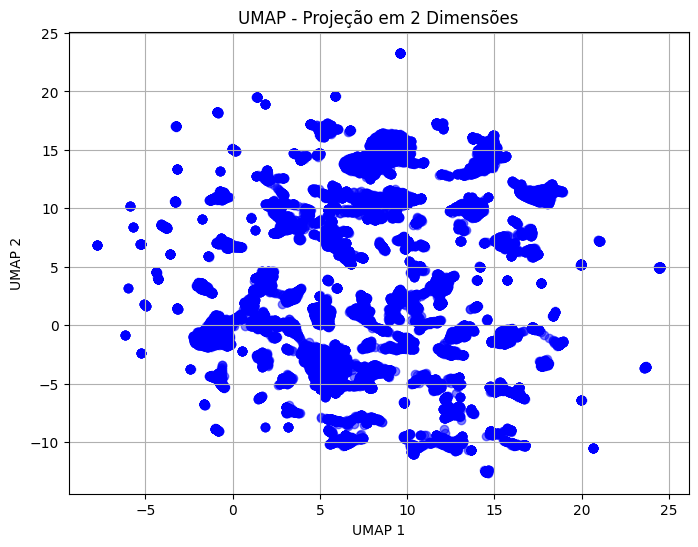

In [53]:
import umap.umap_ as umap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Selecionando apenas as colunas numéricas
num_cols = nomao_df.select_dtypes(include=['float64', 'int64']).columns

# Tratando valores ausentes (substituindo por média ou mediana)
nomao_df[num_cols] = nomao_df[num_cols].fillna(nomao_df[num_cols].mean())  # ou use mediana em vez de média

# Aplicando UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduzindo para 2 componentes
umap_result = umap_model.fit_transform(nomao_df[num_cols])

# Criando um DataFrame com os componentes UMAP
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])

# Plotando os resultados do UMAP
plt.figure(figsize=(8, 6))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.5, c='blue')
plt.title('UMAP - Projeção em 2 Dimensões')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()


## Outliers

# Conclusões da Análise Exploratória

Após explorar o conjunto de dados, podemos concluir que:  

O dataset possui **120** variáveis e **34.466** registros.  
Existe um grande número de colunas ausentes.  
Detectamos que os valores contínuos são divididos em um intervalo de 0 a 1, o que pode configurar uma normalização.
O desbalanceamento sugere a necessidade de ajustes no treinamento dos modelos.
